In [1]:
from os.path import join
import glob
from itertools import compress
import numpy as np
import pandas as pd
import tensorflow as tf
import geopandas as gpd
import matplotlib.pyplot as plt

from model_utils import *
viz = True

In [2]:
# load the data
wd = join("..", "data", "indata_new")
features = ['gebco', 'fabdem', 'jrc_permwa', 'precip', 'ndvi', 'mangrove', 'soilcarbon', 'wind_avg']
columns = features + ['storm', 'region', 'subregion', "geometry", "floodfrac"]
storm = None  # "roanu", None for all events

# generate the GeoDataFrame from non-staggered data
files = [filename for filename in glob.glob(join(wd, "feature_stats", "*.shp"))]
orig_mask = [True if filename.split('.')[-2][-2:] == '_0' else False for filename in files]
orig = list(compress(files, orig_mask))
gdf, columms = format_gdf(orig, columns, storm=storm)
print("Number of unique images:", gdf['event'].nunique())

Number of storms: 8
Number of regions: 16

Binarising floodfrac...
Number of unique images: 35


In [7]:
# calculate quantities of data for loss function
n = len(gdf)
n1 = gdf['floodfrac'].sum()
n0 = n - n1
print("Zeros:", n0)
print("Ones:", n1)

Zeros: 136884
Ones: 6476


In [8]:
# reformat into numpy arrays for tensorflow
Xmats = []
ymats = []

# now calculate X and y matrices
for event in [*gdf['event'].unique()]:
    temp = gdf[gdf.event==str(event)]
    if len(temp) > 0:
        Xmat, ymat = get_matrices(temp, 500, features)
        Xmats.append(Xmat)
        ymats.append(ymat)
        
# calculate weights and flatten labels matrix
ymats_bool = [mat.astype(bool) for mat in ymats]
ymats_flat = [mat.flatten() for mat in ymats]
ymats_flat = [np.expand_dims(mat, -1) for mat in ymats_flat]

In [9]:
# create TensorFlow datasets with batch size 1 (since small dataset)
n = len(Xmats)
ntrain = int(0.6 * n)
ntest = int(0.2 * n)

# create dataset
data = tf.data.Dataset.from_tensor_slices((Xmats, ymats_flat)).batch(1)
train = data.take(ntrain)
test = data.skip(ntrain)
valid = test.skip(ntest)
test = test.take(ntest)

# extract matrices from train for visualisation later
X_train = [element[0].numpy()[0, :, :, :] for element in train]
X_valid = [element[0].numpy()[0, :, :, :] for element in valid]
X_test = [element[0].numpy()[0, :, :, :] for element in test]

y_train = [element[1].numpy()[0, :] for element in train]
y_valid = [element[1].numpy()[0, :] for element in valid]
y_test = [element[1].numpy()[0, :] for element in test]

print("Dataset size:", n)
print("Training size:", len(X_train))
print("Validation size:", len(X_valid))
print("Test size:", len(X_test))

Dataset size: 35
Training size: 21
Validation size: 7
Test size: 7


2022-06-07 22:33:52.954650: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2022-06-07 22:33:57.586878: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


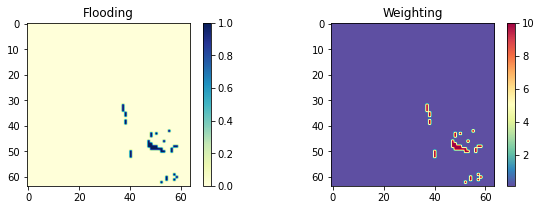

In [10]:
weights_list = [0.1, 10]  # global var

def add_sample_weights(image, label):
    class_weights = tf.constant(weights_list)
    sample_weights = tf.gather(class_weights, indices=tf.cast(label, tf.int32))
    return image, label, sample_weights

# visualise sample weights with label matrix
if viz:
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    for element in train.map(add_sample_weights).take(1):
        im0 = ax[0].imshow(element[1][0, :, :].numpy().reshape(64, 64), cmap="YlGnBu")
        ax[0].set_title("Flooding")
        im = ax[1].imshow(element[2][0, :, :].numpy().reshape(64, 64), cmap="Spectral_r")
        ax[1].set_title("Weighting")
    fig.colorbar(im0, ax=ax[0])
    fig.colorbar(im, ax=ax[1])

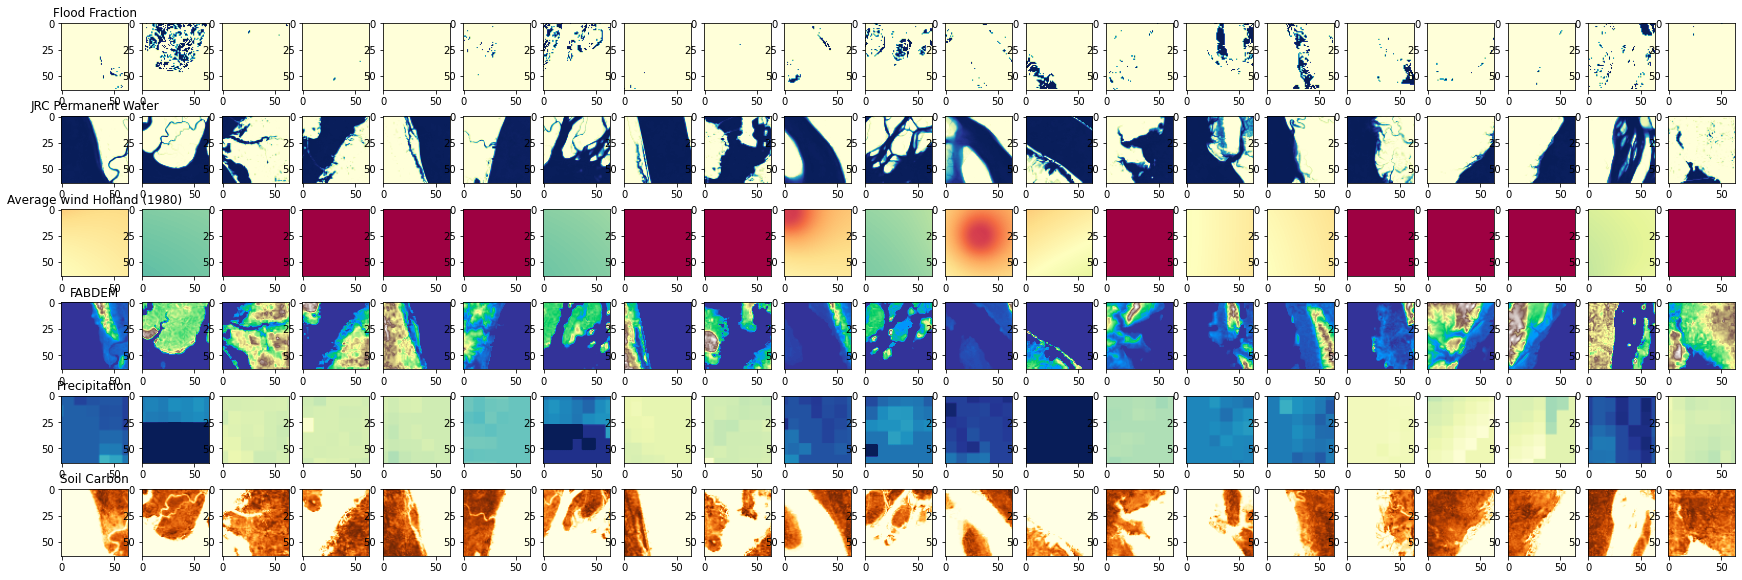

In [11]:
if viz:
    # view training set
    fig, ax = plt.subplots(6, len(y_train), figsize=(30, 10))
    for i, im in enumerate(y_train):
        pos = ax[0, i].imshow(im.reshape(64, 64), cmap="YlGnBu")
        ax[0, 0].set_title(f"Flood Fraction")

    for i, im in enumerate(X_train):
        pos = ax[1, i].imshow(im[:, :, 2], cmap="YlGnBu")
        ax[1, 0].set_title("JRC Permanent Water")

    for i, im in enumerate(X_train):
        pos = ax[3, i].imshow(im[:, :, 0], cmap="terrain", vmin=0)
        ax[3, 0].set_title("FABDEM")

    for i, im in enumerate(X_train):
        pos = ax[2, i].imshow(im[:, :, 7], cmap="Spectral", vmin=8.5, vmax=10.5)
        ax[2, 0].set_title("Average wind Holland (1980)")

    for i, im in enumerate(X_train):
        pos = ax[4, i].imshow(im[:, :, 3], cmap="YlGnBu", vmin=0, vmax=40)
        ax[4, 0].set_title("Precipitation")

    for i, im in enumerate(X_train):
        pos = ax[5, i].imshow(im[:, :, 4], cmap="YlOrBr", vmin=0)
        ax[5, 0].set_title("Soil Carbon")

    plt.savefig(join(wd, "trainingset_binary.png"), bbox_inches="tight")

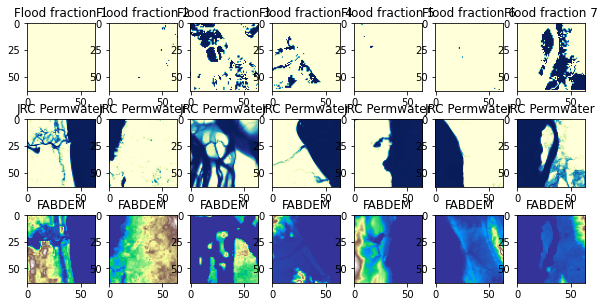

In [12]:
if viz:
    # view test set
    fig, ax = plt.subplots(3, len(y_test), figsize=(10, 5))
    for i, im in enumerate(y_test):
        pos = ax[0, i].imshow(im.reshape(64, 64), cmap="YlGnBu")
        ax[0, i].set_title(f"Flood fraction {i+1}")

    for i, im in enumerate(X_test):
        pos = ax[1, i].imshow(im[:, :, 2], cmap="YlGnBu")
        ax[1, i].set_title("JRC Permwater")

    for i, im in enumerate(X_test):
        pos = ax[2, i].imshow(im[:, :, 0], cmap="terrain", vmin=0)
        ax[2, i].set_title("FABDEM")

    plt.savefig(join(wd, "testset.png"), bbox_inches="tight")

### SCNN
Can either use:
1. A `BinaryCrossentropy` loss with the sigmoid activation function and no one-hot encoding. This requires the array to be flattened to shape ($x\times y$, nchannels).
2. A `SparseCategoricalCrossentropy` with a softmax activation function and one-hot encoding on the predictions only (i.e., labels are never one-hot encoded). This doesn't require the array to be flattened.

#### Model improvements:
1. [ ] Localisation layer to learn image regions (Uselis 2020)
2. [ ] Dilation layers to incorporate more global context without downsampling 
3. [ ] Tuning for optimal weights (Camps-Valls 2021)

In [31]:
from keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Reshape
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Dropout, concatenate
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import MeanIoU, Recall
from tensorflow.keras import Model
from keras.losses import BinaryCrossentropy
from keras import backend as K

def build_scnn(shape=(128, 128, 3), k_init="he_normal"):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    
    x = Conv2D(64, 3, padding="same", activation="relu", kernel_initializer=k_init)(normalized)
    x = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=k_init)(x)
    x = Conv2D(128, 3, padding="same", activation="relu", kernel_initializer=k_init)(x)
    
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(x)
    outputs = Reshape((64 * 64, 1))(outputs)
    scnn = Model(inputs, outputs, name="SCNN")
    return scnn


scnn = build_scnn(shape=(64, 64, len(gdf[features].columns)), k_init="he_normal")
scnn.compile(
    optimizer=SGD(1e-3),
    loss=BinaryCrossentropy(from_logits=True),
    metrics=['accuracy', 'Recall', 'Precision'],
    weighted_metrics=['accuracy', 'Recall', 'Precision'])

weights_list = [0.01, 0.99]  # modify global variable here to play with weights
history = scnn.fit(train.map(add_sample_weights),
                   epochs=40,
                   validation_data=valid,
                   callbacks=EarlyStopping(patience=3))

scnn.summary()

Epoch 1/40
21/21 [==============================] - 2s 62ms/step - loss: 0.0315 - accuracy: 0.9571 - recall: 0.0012 - precision: 0.0176 - val_loss: 0.6940 - val_accuracy: 0.9782 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/40
21/21 [==============================] - 1s 43ms/step - loss: 0.0314 - accuracy: 0.9570 - recall: 0.0017 - precision: 0.0246 - val_loss: 0.6969 - val_accuracy: 0.9782 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/40
21/21 [==============================] - 1s 49ms/step - loss: 0.0314 - accuracy: 0.9568 - recall: 0.0023 - precision: 0.0307 - val_loss: 0.7030 - val_accuracy: 0.9781 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/40
21/21 [==============================] - 1s 46ms/step - loss: 0.0313 - accuracy: 0.9566 - recall: 0.0023 - precision: 0.0288 - val_loss: 0.7115 - val_accuracy: 0.9780 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Model: "SCNN"
______________________________________________________________

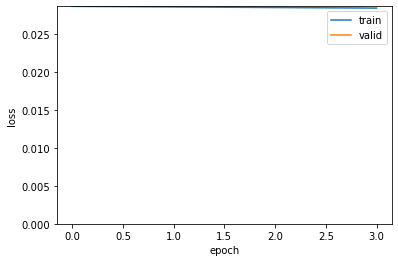

In [23]:
plot_history(history, metric='loss')

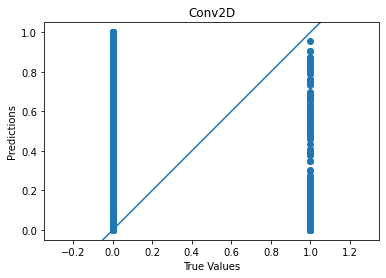

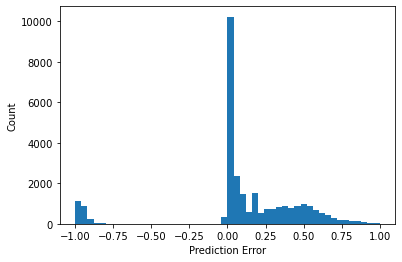

In [25]:
[loss, rmse] = scnn.evaluate(test, verbose=0)[:2]
print("\nTesting set root mean squared error: {:4.2f}".format(rmse))

y_probs = scnn.predict(test)
y_pred = (y_probs > 0.5).astype(float)

plot_prediction(np.array(y_test).flatten(), y_probs.flatten(), "Conv2D")

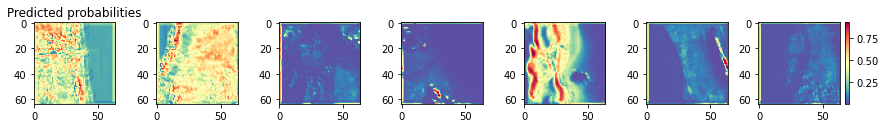

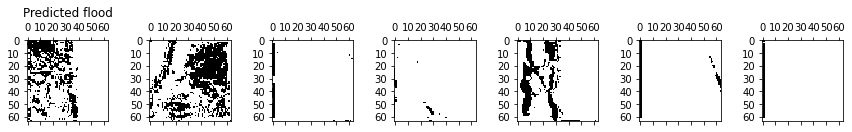

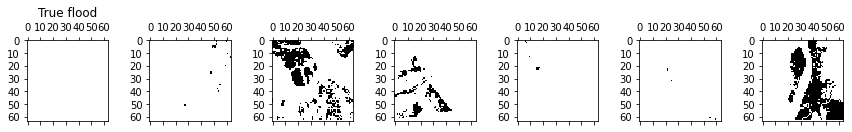

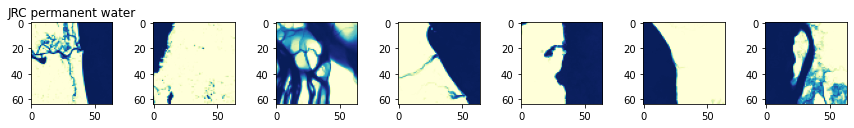

In [26]:
if viz:
    fig, ax = plt.subplots(1, len(y_probs), figsize=(15, 1.5))
    for i, pred in enumerate(y_probs):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="Spectral_r")
    ax[0].set_title("Predicted probabilities")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    fig, ax = plt.subplots(1, len(y_pred), figsize=(15, 1.5))
    for i, pred in enumerate(y_pred):
        im = ax[i].spy(pred.reshape(64, 64))
    ax[0].set_title("Predicted flood")
        
    fig, ax = plt.subplots(1, len(y_test), figsize=(15, 1.5))
    for i, pred in enumerate(y_test):
        im = ax[i].spy(pred.reshape(64, 64))
    ax[0].set_title("True flood")
        
    fig, ax = plt.subplots(1, len(X_test), figsize=(15, 1.5))
    for i, pred in enumerate(X_test):
        im = ax[i].imshow(pred[:, :, 2], cmap="YlGnBu")
    ax[0].set_title("JRC permanent water")

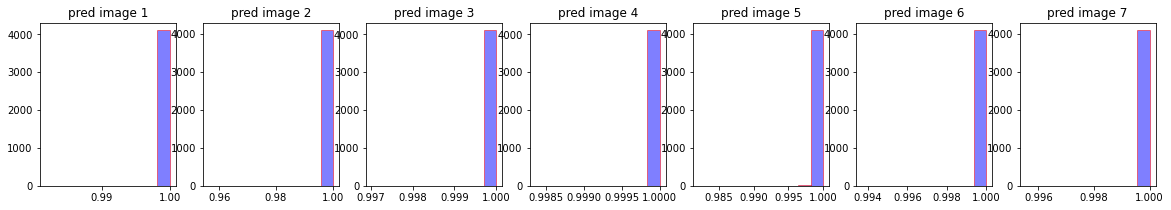

In [45]:
fig, ax = plt.subplots(1, len(y_test), figsize=(20, 3))

for i, _ in enumerate(y_test):
    ax[i].hist(y_pred[i], alpha=0.5, edgecolor="red", color="blue")
    ax[i].set_title(f"pred image {i+1}")

# U-Net
[Keras implementation from here](https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/)

In [27]:
# define the U-Net architecture (from Tutorial)
def double_conv_block(x, depth, k_init):
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer=k_init)(x)
    x = Conv2D(depth, (3, 3), padding="same", activation="relu", kernel_initializer=k_init)(x)
    return x

def downsample_block(x, depth, k_init):
    f = double_conv_block(x, depth, k_init)
    p = MaxPooling2D(2)(f)
    p = Dropout(0.3)(p)
    return f, p

def upsample_block(x, conv_features, depth, k_init):
    x = Conv2DTranspose(depth, 3, 2, padding="same")(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, depth, k_init)
    return x

# compile model using the functional API
def build_unet(shape=(128, 128, 3), k_init="he_normal"):
    inputs = Input(shape=shape)
    normalized = BatchNormalization(axis=3)(inputs)
    
    # encoder
    f1, p1 = downsample_block(normalized, 64, k_init)
    f2, p2 = downsample_block(p1, 128, k_init)
    f3, p3 = downsample_block(p2, 256, k_init)
    f4, p4 = downsample_block(p3, 512, k_init)
    
    # bottleneck
    bottleneck = double_conv_block(p4, 1024, k_init)
    
    # decoder
    u6 = upsample_block(bottleneck, f4, 512, k_init)
    u7 = upsample_block(u6, f3, 256, k_init)
    u8 = upsample_block(u7, f2, 128, k_init)
    u9 = upsample_block(u8, f1, 64, k_init)
    
    # outputs
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(u9)
    outputs = Reshape((64*64, 1))(outputs)
    unet = Model(inputs, outputs, name="U-Net")
    return unet

Epoch 1/40
21/21 [==============================] - 7s 249ms/step - loss: 0.0270 - accuracy: 0.1939 - recall: 0.8391 - precision: 0.0406 - weighted_accuracy: 0.7087 - recall_1: 0.8391 - precision_1: 0.8072 - val_loss: 1.2518 - val_accuracy: 0.0514 - val_recall: 0.9696 - val_precision: 0.0218 - val_weighted_accuracy: 0.0514 - val_recall_1: 0.9696 - val_precision_1: 0.0218
Epoch 2/40
21/21 [==============================] - 5s 229ms/step - loss: 0.0267 - accuracy: 0.1703 - recall: 0.8685 - precision: 0.0407 - weighted_accuracy: 0.7274 - recall_1: 0.8685 - precision_1: 0.8078 - val_loss: 1.2506 - val_accuracy: 0.0365 - val_recall: 0.9792 - val_precision: 0.0217 - val_weighted_accuracy: 0.0365 - val_recall_1: 0.9792 - val_precision_1: 0.0217
Epoch 3/40
21/21 [==============================] - 5s 230ms/step - loss: 0.0266 - accuracy: 0.1496 - recall: 0.9065 - precision: 0.0414 - weighted_accuracy: 0.7536 - recall_1: 0.9065 - precision_1: 0.8103 - val_loss: 1.2464 - val_accuracy: 0.0312 - va

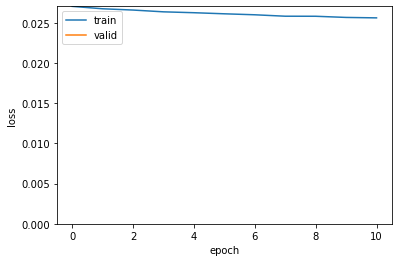

In [36]:
unet = build_unet(shape=(64, 64, len(features)), k_init="he_normal")

unet.compile(optimizer=SGD(1e-3),
             loss=BinaryCrossentropy(from_logits=True),
             metrics=['accuracy', 'Recall', 'Precision'],
             weighted_metrics=['accuracy', 'Recall', 'Precision'],
             sample_weight_mode='temporal')

history = unet.fit(train.map(add_sample_weights),
                   epochs=40,
                   validation_data=valid,
                   callbacks=EarlyStopping(patience=3))

plot_history(history, metric='loss')             


Testing set root mean squared error: 0.08


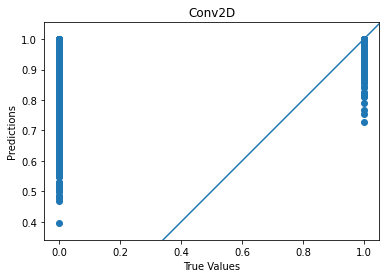

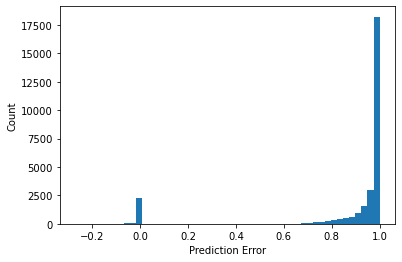

In [37]:
[loss, rmse] = unet.evaluate(test, verbose=0)[:2]
print("\nTesting set root mean squared error: {:4.2f}".format(rmse))

y_probs = unet.predict(test)
y_pred = (y_probs > 0.5).astype(float)

plot_prediction(np.array(y_test).flatten(), y_probs.flatten(), "Conv2D")

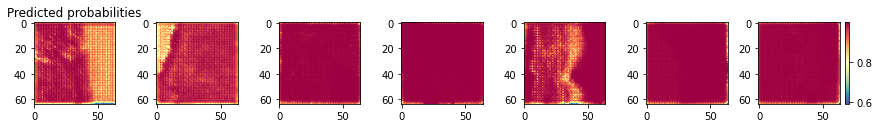

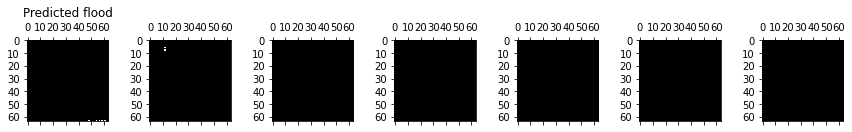

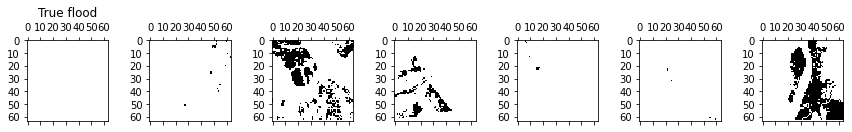

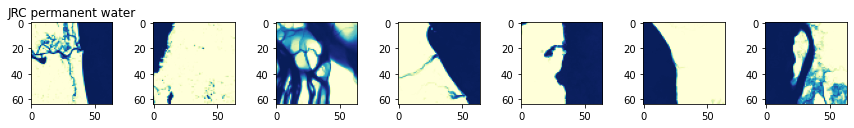

In [38]:
if viz:
    fig, ax = plt.subplots(1, len(y_probs), figsize=(15, 1.5))
    for i, pred in enumerate(y_probs):
        im = ax[i].imshow(pred.reshape(64, 64), cmap="Spectral_r")
    ax[0].set_title("Predicted probabilities")
    fig.colorbar(im, ax=ax[len(y_probs)-1])
    
    fig, ax = plt.subplots(1, len(y_pred), figsize=(15, 1.5))
    for i, pred in enumerate(y_pred):
        im = ax[i].spy(pred.reshape(64, 64))
    ax[0].set_title("Predicted flood")
        
    fig, ax = plt.subplots(1, len(y_test), figsize=(15, 1.5))
    for i, pred in enumerate(y_test):
        im = ax[i].spy(pred.reshape(64, 64))
    ax[0].set_title("True flood")
        
    fig, ax = plt.subplots(1, len(X_test), figsize=(15, 1.5))
    for i, pred in enumerate(X_test):
        im = ax[i].imshow(pred[:, :, 2], cmap="YlGnBu")
    ax[0].set_title("JRC permanent water")

In [ ]:
fig, ax = plt.subplots(1, len(y_test), figsize=(20, 3))

for i, _ in enumerate(y_test):
    ax[i].hist(y_pred[i], alpha=0.5, edgecolor="red", color="blue")
    ax[i].set_title(f"pred image {i+1}")